In [1]:
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

explore data

In [3]:
def percMissing(df):
    #Verify Missing columns
    s = pd.Series()
    for col in df.columns:
        s.at[col] = ((len(df) - df[col].count()) / len(df)) * 100
        df_missing = pd.DataFrame({'col':s.index, 'perc_missing':s.values})

    return df_missing.sort_values(by=['perc_missing'], ascending=False)

In [4]:
def count_unique(df, cols):
    for col in cols:
        print(df[col].value_counts(), '\n')


- read csv and create dataframe
- connect to sql database
- write df to db table


In [7]:
df = pd.read_csv('Voodoo_Test_Business_Case.csv', sep=';')

#fill in mode for missing values in countries 
mode = df['country'].mode().to_list()[0]
df['country'] = df['country'].fillna(mode)

connection = sqlite3.connect('database.db')
df.to_sql('case_table', connection, if_exists='replace')

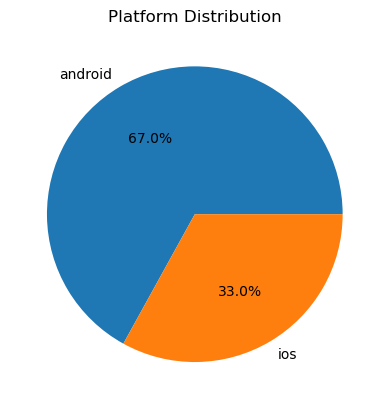

In [8]:
#show platform ratio
query = '''
SELECT platform, count(platform) FROM case_table
GROUP BY platform
'''
f = pd.read_sql_query(query, connection)

fig, ax = plt.subplots()
ax.pie(f['count(platform)'], labels=f['platform'], autopct='%1.1f%%')
ax.set_title('Platform Distribution')
plt.show(fig)

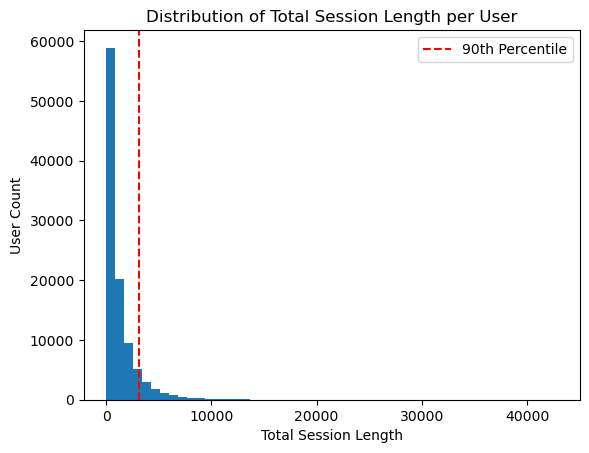

The total session length below which 90% of the data falls is 3073.00.


In [9]:
#show total session by user
query = '''
SELECT user_id, SUM(session_length) as length, COUNT(*) as count
FROM case_table
GROUP BY user_id
ORDER BY count DESC
'''
f = pd.read_sql_query(query, connection)

percentile_90 = np.percentile(f['length'], 90)

fig, ax = plt.subplots()
ax.hist(f['length'], bins=50)
ax.axvline(x=percentile_90, color='r', linestyle='--', label='90th Percentile')
ax.set_xlabel('Total Session Length')
ax.set_ylabel('User Count')
ax.set_title('Distribution of Total Session Length per User')
ax.legend()
plt.show(fig)
print(f"The total session length below which 90% of the data falls is {percentile_90:.2f}.")

In [10]:
#general analysis
query = '''
SELECT user_id, ab_cohort_name as frequency, open_at, publisher_revenue, session_id, fs_shown, rv_shown
FROM case_table
ORDER BY user_id DESC
LIMIT 20
'''
f = pd.read_sql_query(query, connection)

In [11]:
#looking into session length and user_id
query = '''
SELECT user_id, SUM(session_length) as length
FROM case_table
GROUP BY user_id
ORDER BY length DESC
'''
f = pd.read_sql_query(query, connection)
f 

,user_id,length
0,70f3245b-baef-47f5-b450-e29cc967fdce,42860
1,bbc1473a-6176-40f2-a21f-0354552df0b6,41778
2,b60363d1-a043-4cfc-a96b-b9834b27f66d,32974
3,533fc4e5-e8fa-4d69-8280-b72713ba26a0,31606
4,544ee3d6-7658-46c9-8c7c-c567d8fd78e1,31516
...,...,...
102198,0376e7cc-20fd-415b-881f-4fc16be36564,0
102199,026532c0-aa17-44e2-9463-3088bf321440,0
102200,020d63de-2295-4b8f-94dc-b38d30dc6e73,0
102201,019e8057-f95d-4c52-b109-33539d8b833f,0


In [12]:
# check how total revenue and total session_length are correlated. use colors to differentiate different ad frequency. 
query = '''
SELECT user_id, SUM(session_length) AS total_session_time, SUM(publisher_revenue) AS total_revenue, ab_cohort_name as frequency
FROM case_table
GROUP BY user_id
'''
f = pd.read_sql_query(query, connection)
f 

,user_id,total_session_time,total_revenue,frequency
0,0001f899-cf36-4280-814b-29ec5040e5ae,460,0.192197,xHigh
1,0001fe92-eabf-4853-8172-2fc823e406c5,2815,0.018875,xxHigh
2,0002e1dc-9c77-414c-bda1-1d0cd1cb410d,1705,0.013690,xxLow
3,00052647-0669-4fba-8eb1-bca1bcc5f07b,1585,0.093947,control
4,00054564-7e29-4920-bd0d-10fbeb9e57a6,307,0.025320,xxLow
...,...,...,...,...
102198,fffe3032-d94a-4961-8d29-3bee448e2e38,925,0.227722,gameTune
102199,fffecc33-fdc3-4a5a-b908-1cb9fa25cfca,1751,0.283984,xHigh
102200,ffff2876-200b-42c6-bc35-5269b96cdaec,637,0.016635,xLow
102201,ffff989c-34dc-4319-bfdc-fe6a34c1ace0,1769,0.002050,xHigh


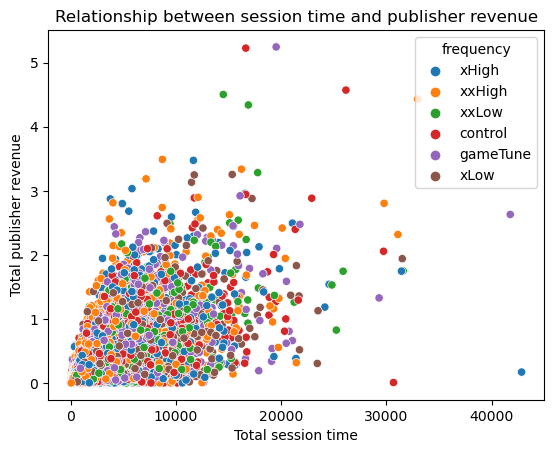

In [13]:
sns.scatterplot(x="total_session_time", y="total_revenue", hue="frequency", data=f)

plt.title("Relationship between session time and publisher revenue")
plt.xlabel("Total session time")
plt.ylabel("Total publisher revenue")
plt.show()

In [14]:
# find if certain ad frequency has longer total session time from one user
query = '''
SELECT ab_cohort_name as frequency, AVG(total_session_time) AS avg_session_time
FROM (
    SELECT user_id, ab_cohort_name, SUM(session_length) AS total_session_time
    FROM case_table
    GROUP BY user_id
) AS user_cohort_sessions
GROUP BY ab_cohort_name;
'''
f = pd.read_sql_query(query, connection)
f 

,frequency,avg_session_time
0,control,1273.808622
1,gameTune,1208.450689
2,xHigh,1231.173201
3,xLow,1290.642962
4,xxHigh,1204.608696
5,xxLow,1301.122619


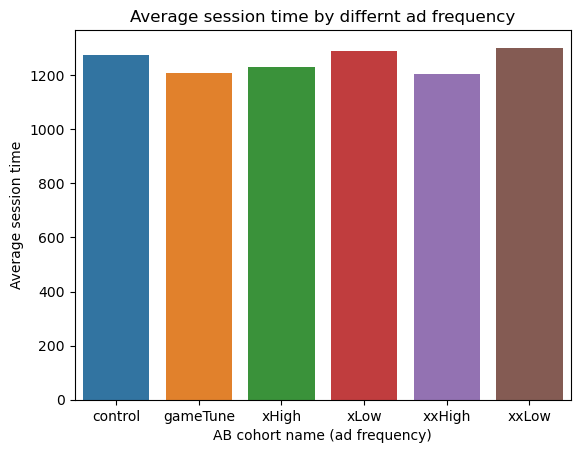

In [15]:
sns.barplot(x="frequency", y="avg_session_time", data=f)

plt.title("Average session time by differnt ad frequency")
plt.xlabel("AB cohort name (ad frequency)")
plt.ylabel("Average session time")
plt.show()


In [16]:
# find if certain ad frequency has larger revenue from one user
query = '''
SELECT ab_cohort_name as frequency, AVG(total_revenue) AS avg_revenue
FROM (
    SELECT user_id, ab_cohort_name, SUM(publisher_revenue) AS total_revenue
    FROM case_table
    GROUP BY user_id
) AS user_cohort_revenue
GROUP BY ab_cohort_name;
'''
f = pd.read_sql_query(query, connection)
f 

,frequency,avg_revenue
0,control,0.141514
1,gameTune,0.141759
2,xHigh,0.146119
3,xLow,0.126054
4,xxHigh,0.147558
5,xxLow,0.121529


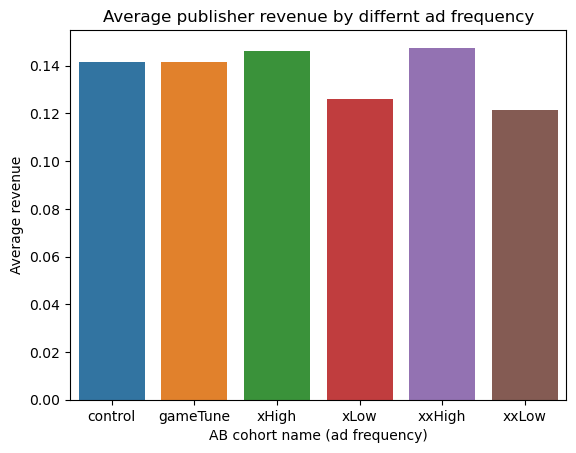

In [17]:
sns.barplot(x="frequency", y="avg_revenue", data=f)

plt.title("Average publisher revenue by differnt ad frequency")
plt.xlabel("AB cohort name (ad frequency)")
plt.ylabel("Average revenue")
plt.show()


In [18]:
# find if certain ad frequency has larger revenue from one user, by certain time segment of the day
query = '''
SELECT user_id, ab_cohort_name,
    CASE
        WHEN CAST(SUBSTR(open_at, 12, 2) AS INTEGER) BETWEEN 5 AND 11 THEN 'Morning'
        WHEN CAST(SUBSTR(open_at, 12, 2) AS INTEGER) BETWEEN 12 AND 18 THEN 'Afternoon'
        WHEN CAST(SUBSTR(open_at, 12, 2) AS INTEGER) BETWEEN 19 AND 23 THEN 'Evening'
        ELSE 'Midnight'
    END AS time_of_day,
    total_revenue
FROM
    (SELECT user_id,
            ab_cohort_name,
            SUM(publisher_revenue) AS total_revenue,
            open_at
        FROM case_table
        GROUP BY user_id, ab_cohort_name, open_at) AS user_cohort_revenue
GROUP by user_id, ab_cohort_name, time_of_day
'''
f = pd.read_sql_query(query, connection)
f 

,user_id,ab_cohort_name,time_of_day,total_revenue
0,0001f899-cf36-4280-814b-29ec5040e5ae,xHigh,Evening,0.099394
1,0001fe92-eabf-4853-8172-2fc823e406c5,xxHigh,Afternoon,0.001224
2,0001fe92-eabf-4853-8172-2fc823e406c5,xxHigh,Evening,0.008656
3,0001fe92-eabf-4853-8172-2fc823e406c5,xxHigh,Morning,0.000000
4,0002e1dc-9c77-414c-bda1-1d0cd1cb410d,xxLow,Afternoon,0.003060
...,...,...,...,...
172961,fffecc33-fdc3-4a5a-b908-1cb9fa25cfca,xHigh,Afternoon,0.087014
172962,fffecc33-fdc3-4a5a-b908-1cb9fa25cfca,xHigh,Evening,0.115630
172963,ffff2876-200b-42c6-bc35-5269b96cdaec,xLow,Morning,0.013885
172964,ffff989c-34dc-4319-bfdc-fe6a34c1ace0,xHigh,Evening,0.000000


In [19]:
# find if certain ad frequency has larger revenue from one user, by certain hour of the day
query = '''
SELECT user_id, ab_cohort_name,
    SUBSTR(open_at, 12, 2) AS hour_of_day,
    total_revenue
FROM
    (SELECT user_id,
            ab_cohort_name,
            SUM(publisher_revenue) AS total_revenue,
            open_at
        FROM case_table
        GROUP BY user_id, ab_cohort_name, open_at) AS user_cohort_revenue
GROUP by user_id, ab_cohort_name, hour_of_day
'''
f = pd.read_sql_query(query, connection)
f 

,user_id,ab_cohort_name,hour_of_day,total_revenue
0,0001f899-cf36-4280-814b-29ec5040e5ae,xHigh,21,0.000000
1,0001f899-cf36-4280-814b-29ec5040e5ae,xHigh,22,0.099394
2,0001fe92-eabf-4853-8172-2fc823e406c5,xxHigh,06,0.000000
3,0001fe92-eabf-4853-8172-2fc823e406c5,xxHigh,16,0.001224
4,0001fe92-eabf-4853-8172-2fc823e406c5,xxHigh,19,0.008656
...,...,...,...,...
264212,fffecc33-fdc3-4a5a-b908-1cb9fa25cfca,xHigh,22,0.115630
264213,ffff2876-200b-42c6-bc35-5269b96cdaec,xLow,09,0.013885
264214,ffff2876-200b-42c6-bc35-5269b96cdaec,xLow,11,0.002750
264215,ffff989c-34dc-4319-bfdc-fe6a34c1ace0,xHigh,21,0.000000


NameError: name 'x_labels' is not defined

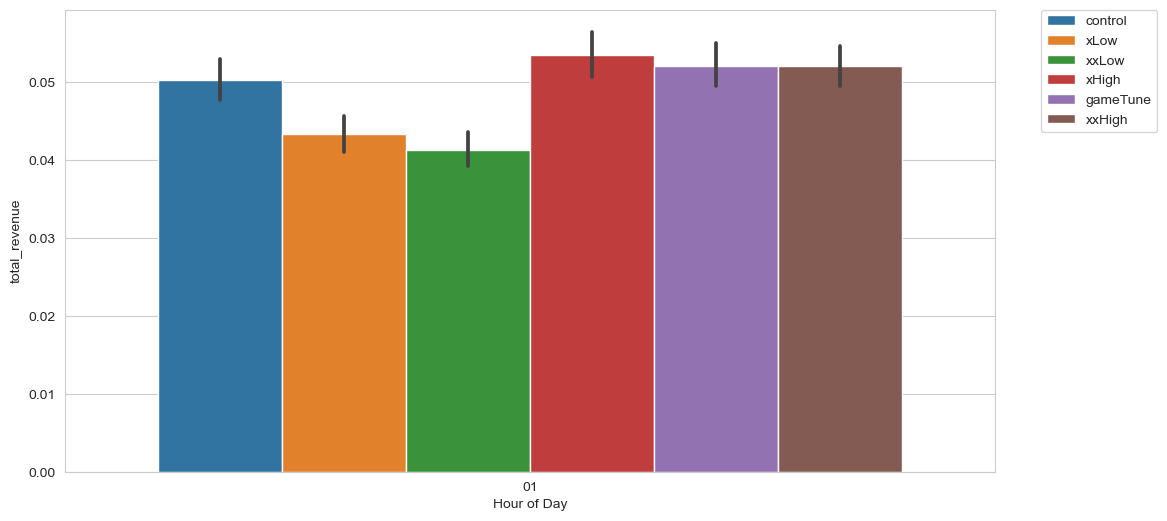

In [20]:
sns.set_style("whitegrid")
fig, ax = plt.subplots(figsize=(12, 6))
sns.barplot(
    x="hour_of_day", 
    y="total_revenue", 
    hue="ab_cohort_name",
    data=f,
    ax=ax,
)
ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

ax.set_xlabel("Hour of Day")
x_labels = ['{}'.format(str(hour).zfill(2)) for hour in range(24)]
ax.set_xticklabels(x_labels, rotation=45, ha='right')
ax.set_ylabel("Total revenue")
ax.set_title("Total revenue by AB Cohort and Hour of Day")
plt.show()

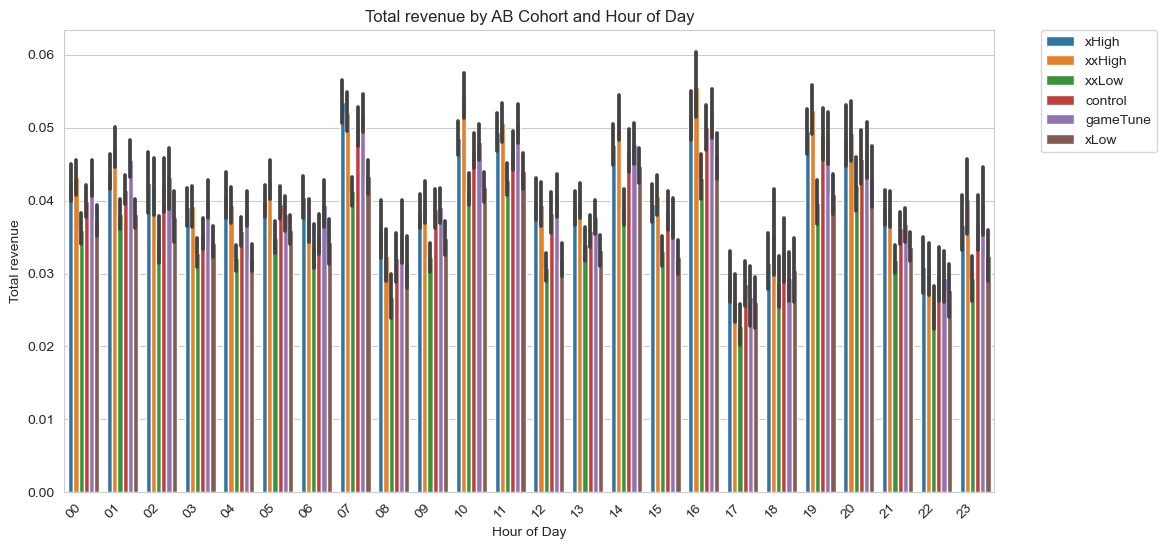

In [95]:
sns.set_style("whitegrid")
fig, ax = plt.subplots(figsize=(12, 6))
sns.barplot(
    x="hour_of_day", 
    y="total_revenue", 
    hue="ab_cohort_name",
    data=f,
    ax=ax,
)
ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

ax.set_xlabel("Hour of Day")
x_labels = ['{}'.format(str(hour).zfill(2)) for hour in range(24)]
ax.set_xticklabels(x_labels, rotation=45, ha='right')
ax.set_ylabel("Total revenue")
ax.set_title("Total revenue by AB Cohort and Hour of Day")
plt.show()
